# Data Processing

The primary goal is to process resistivity data. Firstly, it is necessary to import the required libraries.


In [4]:
import numpy as np
import utm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pygimli.frameworks import harmfit
from sklearn.ensemble import IsolationForest
from matplotlib.colors import LogNorm
import geopandas as gpd
import fiona
import pandas as pd
import seaborn as sns
import pygimli as pg
from scipy import interpolate

Following that, it is recommended to execute the functions that have been defined to read the original data and perform various processing tasks.

In [5]:
# Function to read the data with UTM coord. Sys.
def read_data_UTM(filepath):
    EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, Rho5, Gamma = np.genfromtxt(filepath, skip_header=0, delimiter=',', unpack=True)
    # EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, nan_data, Rho5, Gamma, BFI, lfd, Datum, Zeit = np.genfromtxt(filepath, skip_header=1, delimiter=',', unpack=True)
    data = np.column_stack((EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, Rho5, Gamma))
    return data

# Function to read the data
def read_data(filepath):
    # Try to read the data with ',' as the delimiter
    try:
        # EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, Rho5, Rho6, Gamma = np.genfromtxt(filepath, skip_header=1, delimiter=';', unpack=True)
        EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, nan_data, Rho5, Gamma, BFI, lfd, Datum, Zeit = np.genfromtxt(filepath, skip_header=1, delimiter=';', unpack=True)

        # EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, Rho6, Gamma = np.genfromtxt(filepath, skip_header=1, delimiter=',', unpack=True)
        Eutm, Nutm, zone, letter = utm.from_latlon(NdecDeg, EdecDeg, 33, 'U')
        # data = np.column_stack((Eutm, Nutm, H, Rho1, Rho2, Rho3, Rho4, Rho5, Rho6, Gamma))
        data = np.column_stack((Eutm, Nutm, H, Rho1, Rho2, Rho3, Rho4, Rho5, Gamma))
        return data
    except ValueError:
        # If reading with ',' delimiter fails, try reading with ';' as the delimiter
        # EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, Rho6, Gamma = np.genfromtxt(filepath, skip_header=1, delimiter=';', unpack=True)
        EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, nan_data, Rho5, Gamma, BFI, lfd, Datum, Zeit = np.genfromtxt(filepath, skip_header=1, delimiter=',', unpack=True)
        Eutm, Nutm, zone, letter = utm.from_latlon(NdecDeg, EdecDeg, 33, 'U')
        # data = np.column_stack((Eutm, Nutm, H, Rho1, Rho2, Rho3, Rho4, Rho5, Rho6, Gamma))
        data = np.column_stack((Eutm, Nutm, H, Rho1, Rho2, Rho3, Rho4, Rho5, Gamma))
        return data

def read_data_Aus(filepath):
    data_aus= np.genfromtxt(filepath, skip_header=1, delimiter=';', unpack=True)
    #achseFFT = data_aus[55]  
    # Find indices where Achse-5-U-FFT-Frq is not equal to 50
    indices_to_remove = np.where(data_aus[54] != 50)
    
    # Remove rows where Achse5-U-FFT-Frq is not equal to 50
    filtered_data = np.delete(data_aus, indices_to_remove, axis=1)
    
    EdecDeg, NdecDeg, H = filtered_data[0], filtered_data[1], filtered_data[2]
    Rho1, Rho2, Rho3, Rho4, Rho6 = filtered_data[11], filtered_data[12], filtered_data[13], filtered_data[14], filtered_data[16]
    Gamma = filtered_data[30]
    Eutm, Nutm, zone, letter = utm.from_latlon(NdecDeg, EdecDeg, 33, 'U')
    data = np.column_stack((Eutm, Nutm, H, Rho1, Rho2, Rho3, Rho4, Rho6, Gamma))
    return data


def read_data_Grossbeeren(filepath):
    data = np.genfromtxt(filepath, skip_header=1, unpack=True)

    # Find indices where Achse-5-U-FFT-Frq is not equal to 50
    indices_to_remove = np.where(data[44] != 50)
    
    # Remove rows where Achse5-U-FFT-Frq is not equal to 50
    filtered_data = np.delete(data, indices_to_remove, axis=1)
    filtered_data = filtered_data.T
    
    EdecDeg, NdecDeg, H = filtered_data.T[61], filtered_data.T[60], filtered_data.T[62]
    Rho1, Rho2, Rho3, Rho4, Rho6 = filtered_data.T[8], filtered_data.T[9], filtered_data.T[10], filtered_data.T[11], filtered_data.T[13]
    Gamma = filtered_data.T[20]
    Eutm, Nutm, zone, letter = utm.from_latlon(NdecDeg, EdecDeg, 33, 'U')
    data = np.column_stack((Eutm, Nutm, H, Rho1, Rho2, Rho3, Rho4, Rho6, Gamma))
    return data


def read_data_lineIndexed(filepath):
    EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, Rho5, Gamma, line_index = np.genfromtxt(filepath, skip_header=0, delimiter=',', unpack=True)
    # EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, nan_data, Rho5, Gamma, BFI, lfd, Datum, Zeit = np.genfromtxt(filepath, skip_header=1, delimiter=',', unpack=True)
    data = np.column_stack((EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, Rho5, Gamma, line_index))
    return data


def read_data_from_csv(data_array):
    # Unpack columns from the data array
    EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, Rho5, Gamma, line_index = np.hsplit(data_array, 10)
    
    # Convert columns to 1D arrays
    EdecDeg = np.squeeze(EdecDeg)
    NdecDeg = np.squeeze(NdecDeg)
    H = np.squeeze(H)
    Rho1 = np.squeeze(Rho1)
    Rho2 = np.squeeze(Rho2)
    Rho3 = np.squeeze(Rho3)
    Rho4 = np.squeeze(Rho4)
    Rho5 = np.squeeze(Rho5)
    Gamma = np.squeeze(Gamma)
    line_index = np.squeeze(line_index)
    
    # Stack the columns horizontally
    data = np.column_stack((EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, Rho5, Gamma, line_index))
    
    return data




class LineDetector:
    def __init__(self, minPoints, maxAngleDeviation=20.):
        self.minPoints = minPoints   # Minimum number of points to consider a line
        self.maxAngleDeviation = maxAngleDeviation

    def detect_lines(self, rx, ry):
        """Split data into lines based on angle deviation and minimum points."""
        dummy = np.zeros_like(rx, dtype=int)
        line = np.zeros_like(rx, dtype=int)
        li = 0
        prev_angle = None

        for ri in range(1, len(rx)):
            dummy[ri - 1] = li

            # Calculate the angle between the current and previous points
            angle = np.arctan2(ry[ri] - ry[ri - 1], rx[ri] - rx[ri - 1]) * 180 / np.pi

            # Check if the angle deviation exceeds the threshold
            if prev_angle is not None and abs(angle - prev_angle) > self.maxAngleDeviation:
                li += 1

            prev_angle = angle
            dummy[ri] = li

        # Check if a line contains at least minPoints
        line_counts = np.bincount(dummy)
        for line_idx, point_count in enumerate(line_counts):
            if point_count < self.minPoints:
                line[dummy == line_idx] = -1  # Mark lines with less than minPoints as -1

        return self._sort_lines(rx, ry, line, dummy)
    
    def get_point_line_indices(self, rx, ry, line_indices):
        """Return the line index for each point."""
        point_line_indices = np.zeros_like(rx, dtype=int)
    
        for point_idx, (x, y, line_idx) in enumerate(zip(rx, ry, line_indices.astype(int))):
            point_line_indices[point_idx] = line_idx
    
        # Append the point_line_indices as a new column to the original data
        data_with_line_indices = np.column_stack((rx, ry, point_line_indices))
    
        return data_with_line_indices
    
    def _sort_lines(self, rx, ry, line, dummy):
        """
        Sort line elements.
        """
        means = []
        for li in np.unique(dummy):
            means.append(np.mean(ry[dummy == li], axis=0))
    
        lsorted = np.argsort(means)
        for li, lold in enumerate(lsorted):
            line[dummy == lold] = li + 1
            
        return rx, ry, line


# Function to plot original data's areal plot
def plot_data(data_file, spacing_labels, farmName, refPoints, data_type, cmap='Spectral_r', vmin=10, vmax=1000):
    # Read original data
    data = read_data_Aus(data_file)
    # Read processed data
    # data = read_data(data_file)
    
    # Create a multi-page PDF file to save the plots
    pdf_filename = f"Data {data_type}_{farmName}.pdf"
    pdf_pages = PdfPages(pdf_filename)

    for i, spacing in enumerate(spacing_labels):
        # Create a new figure for each spacing plot
        plt.figure(figsize=(8, 6))
        
        # Extract UTM coordinates (Easting and Northing) for the current spacing
        x_coords = data[:, 0]  # UTM Easting
        y_coords = data[:, 1]  # UTM Northing
        
        # Draw the areal plot for the original data points
        sc = plt.scatter(x_coords, y_coords, s=0.7, c=data[:, i + 3], cmap='Spectral_r', norm=LogNorm(vmin=vmin, vmax=vmax))
        
        # Plot the reference points on the subplot
        plt.scatter(refPoints[:,1], refPoints[:,2], c='red', marker='x', s=40, label='Reference Points')
        
        # Annotate each reference point with its corresponding index (number)
        for j, txt in enumerate(refPoints[:, 0]):
            plt.annotate(txt, (refPoints[:,1][j], refPoints[:,2][j]), fontsize=10, color='black', ha='right')
        
        # colorbar
        plt.colorbar(sc)

        # Set plot labels and title
        plt.xlabel('Easting (UTM)')
        plt.ylabel('Northing (UTM)')
        plt.title(f'Data {data_type} - {spacing} - {farmName}', y=1.03)
        # Equalize the x and y axes
        plt.axis('equal')
        # Save the current plot to the PDF file
        pdf_pages.savefig()
        plt.show()

        # Close the current figure
        plt.close()

    # Close the PDF file
    pdf_pages.close()
    return data




def plot_data_subplots(data_file, spacing_labels, farmName, refPoints, data_type, cmap='Spectral_r', vmin=10, vmax=1000): 
    data = None
    try:
        data = read_data_Aus(data_file)

    except Exception as e:
        print(f"Failed to read data with read_data_lineIndexed: {e}. Trying read_data_Aus.")
    
       
    # Read original data
    # data = read_data_Aus(data_file)
    #data = read_data_lineIndexed(data_file)
    # Read processed data
    # data = read_data(data_file)

    # Create a multi-page PDF file to save the plots
    pdf_filename = f"Data {data_type}_{farmName}_subplot.pdf"
    pdf_pages = PdfPages(pdf_filename)

    # Determine the number of rows and columns for the subplot grid based on the number of spacings
    num_plots = len(spacing_labels) + 1
    num_cols = 3  # Define the number of columns for the subplot grid
    num_rows = -(-num_plots // num_cols)  # Calculate the number of rows needed

    # Create a new figure for the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    for i in range(num_plots):
        # Extract UTM coordinates (Easting and Northing) for the current spacing
        x_coords = data[:, 0]  # UTM Easting
        y_coords = data[:, 1]  # UTM Northing

        # Determine the subplot index for the current spacing
        subplot_row = i // num_cols
        subplot_col = i % num_cols

        # Create individual subplots for each spacing
        ax = axes[subplot_row, subplot_col] if num_rows > 1 else axes[i % num_cols]
        sc = ax.scatter(x_coords, y_coords, s=0.7, c=data[:, i + 3], cmap='Spectral_r', norm=LogNorm(vmin=vmin, vmax=vmax))
        ax.scatter(refPoints[:,1], refPoints[:,2], c='red', marker='x', s=40, label='Reference Points')

        # Set plot labels and title for individual subplots
        ax.set_xlabel('Easting (UTM)')
        ax.set_ylabel('Northing (UTM)')
        if i == num_plots - 1:
            ax.set_title('Fram Location')  # Title for the last subplot
            pg.viewer.mpl.underlayBKGMap(ax, mode='DOP', utmzone=33, epsg=0, uuid='8102b4d5-7fdb-a6a0-d710-890a1caab5c3', usetls=False, origin=None)
        else:
            ax.set_title(f'Spacing {i + 1}')  # Title for other subplots

    # Add a main title for the page
    plt.suptitle(f"{data_type} Data {farmName} farm", fontsize=16)

    # Add a colorbar to the right of the subplots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust these values for the colorbar position and size
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Ohm.m')  # Change 'Color Bar Title' to your preferred label

    # Adjust layout and save the plots
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    pdf_pages.savefig()
    plt.show()

    # Close the PDF file and return the data
    pdf_pages.close()
    return data



def plot_procesed_subplots(data_file, spacing_labels, farmName, refPoints, data_type, cmap='Spectral_r', vmin=10, vmax=1000): 
    data = read_data_lineIndexed(data_file)

    # Create a multi-page PDF file to save the plots
    pdf_filename = f"{farmName}_subplot_harmfitted {data_type}.pdf"
    pdf_pages = PdfPages(pdf_filename)

    # Determine the number of rows and columns for the subplot grid based on the number of spacings
    num_plots = len(spacing_labels) + 1
    num_cols = 3  # Define the number of columns for the subplot grid
    num_rows = -(-num_plots // num_cols)  # Calculate the number of rows needed

    # Create a new figure for the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    for i in range(num_plots):
        # Extract UTM coordinates (Easting and Northing) for the current spacing
        x_coords = data[:, 0]  # UTM Easting
        y_coords = data[:, 1]  # UTM Northing

        # Determine the subplot index for the current spacing
        subplot_row = i // num_cols
        subplot_col = i % num_cols

        # Create individual subplots for each spacing
        ax = axes[subplot_row, subplot_col] if num_rows > 1 else axes[i % num_cols]
        sc = ax.scatter(x_coords, y_coords, s=0.7, c=data[:, i + 3], cmap='Spectral_r', norm=LogNorm(vmin=vmin, vmax=vmax))
        # ax.scatter(refPoints['E'], refPoints['N'], c='red', marker='x', s=40, label='Reference Points')

        # Set plot labels and title for individual subplots
        ax.set_xlabel('Easting (UTM)')
        ax.set_ylabel('Northing (UTM)')
        if i == num_plots - 1:
            ax.set_title('Fram Location')  # Title for the last subplot
            pg.viewer.mpl.underlayBKGMap(ax, mode='DOP', utmzone=33, epsg=0, uuid='8102b4d5-7fdb-a6a0-d710-890a1caab5c3', usetls=False, origin=None)
        else:
            ax.set_title(f'Spacing {i + 1}')  # Title for other subplots

    # Add a main title for the page
    plt.suptitle(f"Harmfit on {data_type} Data {farmName} farm", fontsize=16)

    # Add a colorbar to the right of the subplots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust these values for the colorbar position and size
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Ohm.m')  # Change 'Color Bar Title' to your preferred label

    # Adjust layout and save the plots
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    pdf_pages.savefig()
    plt.show()

    # Close the PDF file and return the data
    pdf_pages.close()
    return data


# Function to perform Isolation Forest on original data
def isolation_forest_outlier_detection(data_file, num_spacing, refPoints_df, farmName):
    # Set a fixed random seed
    np.random.seed(42)
    
    data_original = read_data_Aus(data_file)
    
    downsampled_data = data_original[::2]
    
    # Create an array to store the Isolation Forest results
    resistivity_data = downsampled_data[:,3:8]
    num_spacing = resistivity_data.shape[1]  # 5 spacing in Geophilus system# should be outside of the function

    Isolation_Forest = np.empty((len(resistivity_data), num_spacing + 4))
    Isolation_Forest[:] = np.nan

    # Store the (X,Y) UTM coordinates, H_original, and Gamma_original
    Isolation_Forest[:, 0] = downsampled_data[:,0]
    Isolation_Forest[:, 1] = downsampled_data[:,1]
    Isolation_Forest[:, 2] = downsampled_data[:,2]
    Isolation_Forest[:, -1] = downsampled_data[:,8]

    num_outliers = np.zeros(num_spacing)  # Array to store the number of outliers per spacing

    # Create a multi-page PDF file to save the plots
    pdf_filename = f"Isolation_Forest_{farmName}.pdf"
    pdf_pages = PdfPages(pdf_filename)
    
    
    for spacing in range(num_spacing):
        # Original data
        resistivity_values_original = np.log(resistivity_data[:, spacing])

        # Outlier detection using Isolation Forest on original data
        isolation_forest = IsolationForest()
        outliers_iforest = isolation_forest.fit_predict(resistivity_values_original.reshape(-1, 1))

        # Count the number of outliers
        num_outliers[spacing] = np.sum(outliers_iforest == -1)

        # Store the Isolation Forest results for each spacing
        selected_values = np.exp(resistivity_values_original[outliers_iforest == 1])
        
        Isolation_Forest[outliers_iforest == 1, spacing + 3] = selected_values
        
        # Draw the areal plot for the Isolation Forest data points
        plt.figure(figsize=(8, 6))
        sc = plt.scatter(Isolation_Forest[:, 0], Isolation_Forest[:, 1],
                         s=0.7, c=Isolation_Forest[:, spacing + 3], cmap='Spectral_r', norm=LogNorm(vmin=10, vmax=1000))
        
        # Plot the reference points on the subplot
        plt.scatter(refPoints_df['E'], refPoints_df['N'], c='red', marker='x', s=50, label='Reference Points')
    
        # Annotate each reference point with its corresponding index (number)
        for j, txt in enumerate(refPoints_df['Name']):
            plt.annotate(txt, (refPoints_df['E'][j], refPoints_df['N'][j]), fontsize=9, color='black')
    
        # colorbar
        plt.colorbar(sc)
    
        # Set plot labels and title
        plt.xlabel('Easting (UTM)')
        plt.ylabel('Northing (UTM)')
        plt.title(f'Isolation Forest - Spacing {spacing + 1} - {farmName}', y=1.03)
        plt.axis('equal')

        # Save the current plot to the PDF file
        pdf_pages.savefig()
        plt.show()
    
        # Close the current figure
        plt.close()
    
    # Close the PDF file
    pdf_pages.close()
        
    # Save the Isolation Forest data to a single text file
    output_filename = f"Isolation_{farmName.replace(' ', '')}.txt"
    header = 'x\ty\th\t' + '\t'.join([f"Rho Spacing {i+1}" for i in range(num_spacing)]) + '\tGamma'
    np.savetxt(output_filename, Isolation_Forest, delimiter='\t', header=header)

    # Print the number of outliers and non-outliers per spacing
    for spacing in range(num_spacing):
        print(f"Spacing {spacing + 1}: Outliers = {int(num_outliers[spacing])}, Non-Outliers = {int(len(resistivity_data) - num_outliers[spacing])}")

    return Isolation_Forest



def harmfit_cal(data, x, y, h, Gamma, lx, nc=30, error=0.01):
    # Filter out invalid data (nan values)
    valid_indices = np.isfinite(data)
    valid_data = data[valid_indices]

    if len(valid_data) == 0:
        print("No valid data points found. Skipping harmfit.")
        return [], [], []

    xline = np.sqrt((x - x[0]) ** 2 + (y - y[0]) ** 2)

    # Perform harmfit on the valid data
    harmfit_result, _ = harmfit(np.log(valid_data), x=xline[valid_indices], nc=nc, error=error)

    # # Create a new array to store the harmfit result with nan values restored
    # harmfit_result_with_nan = np.empty(len(data))
    # harmfit_result_with_nan[:] = np.nan
    # harmfit_result_with_nan[valid_indices] = np.exp(harmfit_result)

    x_harmfitted = x.copy()
    y_harmfitted = y.copy()
    h_harmfitted = h.copy()
    Gamma_harmfitted = Gamma.copy()
    lx_harmfitted = lx.copy()

    harmfitted_result_with_XY = np.column_stack((x_harmfitted[valid_indices], 
                                                 y_harmfitted[valid_indices], 
                                                 h_harmfitted[valid_indices],
                                                 np.exp(harmfit_result),
                                                 Gamma_harmfitted[valid_indices],
                                                 lx_harmfitted[valid_indices]))
    return harmfitted_result_with_XY




def harmfit_fn(data_file, spacing_labels, farmName_Original, refPoints_df, data_type, cmap='Spectral_r', vmin=10, vmax=1000):
    pdf_filename = f"harmfit on {data_type} _ {farmName_Original}.pdf"
    pdf_pages = PdfPages(pdf_filename)
    nc = 30
    
    data = read_data_lineIndexed(data_file)
    data_filtered = data[data[:, -1] != 0] # remove individual points
    selected_lines = np.unique(data_filtered[:,-1])
    all_x_y = set()  # To store unique x and y coordinates

    # all_harmfitted_data = []  # List to store harmfitted data for all spacings
    # H_values_all = []  # List to store H values
    # Gamma_values_all = []  # List to store Gamma values
    # x_all = []  # List to store UTM x values
    # y_all = []  # List to store UTM y values
    harmfitted_final_result = []

    # Iterate over each spacing
    for i, spacing in enumerate(spacing_labels):
        # x_all = []
        # y_all = []
        # h_all = []
        # harmfitted_spacing_data_list_spacing = []  # List to store harmfitted data for the current spacing
        # line_index_all = []
        harmfitted_for_each_spacing = []
        # Iterate over each selected line
        for line_num in selected_lines:
            point_indices_of_interest = np.where(data_filtered[:, -1] == line_num)[0]
            point_indices_of_interest = point_indices_of_interest.astype(int)
            
            for index in point_indices_of_interest:
                if index < len(data_filtered):
                    x_coords = data_filtered[point_indices_of_interest, 0]
                    y_coords = data_filtered[point_indices_of_interest, 1]
                    H_values = data_filtered[point_indices_of_interest, 2]
                    line_index = data_filtered[point_indices_of_interest, -1]
                    Gamma_values = data_filtered[point_indices_of_interest, 8]  
        
                    resistivity_spacing_line = data_filtered[point_indices_of_interest, i + 3]
            
                    harmfitted_result_with_XY = harmfit_cal(
                        data=resistivity_spacing_line, x=x_coords, y=y_coords,
                        h=H_values, Gamma=Gamma_values, lx=line_index,
                        nc=nc,
                        error=0.01)
            harmfitted_for_each_spacing.extend(harmfitted_result_with_XY)
            # Add x and y coordinates to the set of all_x_y
            all_x_y.update(zip(x_coords, y_coords))
        # Append harmfitted data for the current spacing
        harmfitted_final_result.append(harmfitted_for_each_spacing)
        # Draw the areal plot for all lines together for the current spacing
        plt.figure(figsize=(8, 6))
        x_harm = np.array(harmfitted_for_each_spacing)[:,0].flatten()
        y_harm = np.array(harmfitted_for_each_spacing)[:,1].flatten()
        res_harm = np.array(harmfitted_for_each_spacing)[:,3].flatten()
        sc = plt.scatter(x_harm, y_harm, s=0.7, c=res_harm, cmap='Spectral_r', norm=LogNorm(vmin=10, vmax=1000))

        # colorbar
        plt.colorbar(sc)

        # Set plot labels and title
        plt.xlabel('Easting (UTM)')
        plt.ylabel('Northing (UTM)')
        plt.title(f'Harmfit on {data_type} - {spacing} - {farmName_Original}', y=1.03)
        plt.axis('equal')

        # Save the current plot to the PDF file
        pdf_pages.savefig()
        plt.show()

        plt.close()

    # Close the PDF file
    pdf_pages.close()
    
     
    # save harmfitted data
    data_dict = {}  # Dictionary to store harmfitted data for each unique (x, y) coordinate
    # Iterate over each element in harmfitted_final_result
    for spacing_idx, spacing_result in enumerate(harmfitted_final_result):
        for spacing_data in spacing_result:
            x_coord, y_coord = spacing_data[:2]  # Extract x and y coordinates
    
            # Check if (x, y) coordinate already exists in the dictionary
            if (x_coord, y_coord) not in data_dict:
                data_dict[(x_coord, y_coord)] = {
                    'x': x_coord,
                    'y': y_coord,
                    'h': None,
                    'harmfitted': [None] * len(spacing_labels),
                    'gamma': None,
                    'line_index': None
                }
    
    # iterate over each element in harmfitted_final_result again to assign the corresponding data
    for spacing_idx, spacing_result in enumerate(harmfitted_final_result):
        for spacing_data in spacing_result:
            x_coord, y_coord = spacing_data[:2]  # Extract x and y coordinates
            h_value = spacing_data[2]  # Extract h value
            harmfitted_values = spacing_data[3]  # Extract harmfitted values
            gamma_value = spacing_data[4]  # Extract gamma value
            line_index = spacing_data[5]  # Extract line index
    
            # Assign the corresponding data to the (x, y) coordinate in the dictionary
            data_dict[(x_coord, y_coord)]['h'] = h_value
            data_dict[(x_coord, y_coord)]['harmfitted'][spacing_idx] = harmfitted_values
            data_dict[(x_coord, y_coord)]['gamma'] = gamma_value
            data_dict[(x_coord, y_coord)]['line_index'] = line_index
    
    # Convert the dictionary values to a list of dictionaries
    final_harmfitted_data = list(data_dict.values())
    
    # Create a 2D array from the list of dictionaries with the desired structure
    harmfitted_array = np.array([(d['x'], d['y'], d['h']) + tuple(d['harmfitted']) + (d['gamma'], d['line_index']) for d in final_harmfitted_data])

    # Define the file name for saving the CSV
    txt_filename = f"harmfitted_{data_type}_{farmName_Original}.txt"
    # Convert the harmfitted_array to float64 type
    harmfitted_array_float64 = harmfitted_array.astype(np.float64)
    
    # Save the harmfitted_array to a CSV file
    np.savetxt(txt_filename, harmfitted_array_float64, delimiter=',', header='x,y,h,harmfitted_1,harmfitted_2,harmfitted_3,harmfitted_4,harmfitted_5,gamma,line_index', fmt='%0.8f', comments='')

    return harmfitted_array







def zscore_outliers(data_file,farmName_Original, spacing_labels, refPoints_df):
    data = read_data_lineIndexed(data_file)
    data_filtered = data[data[:, -1] != 0] #remove individual points
    selected_lines = np.unique(data_filtered[:,-1])
    num_spacing = data[:, 3:8].shape[1]
    # Create the PDF for saving plots
    pdf_filename = f"zscore_on_original_{farmName_Original}.pdf"
    pdf_pages = PdfPages(pdf_filename)
    # Create arrays to store the data columns
    result_data = []
    c_values =[]

    # Iterate over each spacing
    for i, spacing in enumerate(spacing_labels):
        plt.figure(figsize=(8, 6))
        x = []
        y = []
        h = []
        c = []
        gamma = []
        line_index =[]
        
        for line_num in selected_lines:
            point_indices_of_interest = np.where(data_filtered[:, -1] == line_num)[0]
            x_line = data_filtered[point_indices_of_interest, 0]
            y_line = data_filtered[point_indices_of_interest, 1]
            h_line = data_filtered[point_indices_of_interest, 2]
            gamma_line = data_filtered[point_indices_of_interest, 8]
            line_index_line = data_filtered[point_indices_of_interest, -1]

            resistivity_spacing = data_filtered[point_indices_of_interest, i + 3]
            
            # Detect outliers using the Z-score method
            from scipy import stats
            z_scores = np.abs(stats.zscore(resistivity_spacing))
            zmin = 0.9
            zmax = 4
            outliers = (z_scores < zmin) | (z_scores > zmax)

            # Replace outliers with the mean of adjacent points
            replace_outliers_with_mean(resistivity_spacing, outliers)
  
            smoothed_line = smooth_outliers(x_line, resistivity_spacing, outliers)
    
            # Append data for the current line to the arrays
            x.extend(x_line)
            y.extend(y_line)
            h.extend(gamma_line)
            gamma.extend(gamma_line)
            c.extend(smoothed_line)
            line_index.extend(line_index_line)
            
        c_values.append(c)
        # Create the scatter plot for the current spacing
        sc = plt.scatter(x, y, s=0.7, c=c, cmap='Spectral_r', norm=LogNorm(vmin=10, vmax=1000))
        plt.xlim(min(x), max(x))
        plt.ylim(min(y), max(y))
        # Plot the reference points on the subplot
        # plt.scatter(refPoints_df['E'], refPoints_df['N'], c='red', marker='x', s=30, label='Reference Points')
    
        # # Annotate each reference point with its corresponding index (number)
        # for j, txt in enumerate(refPoints_df['Name']):
        #     plt.annotate(txt, (refPoints_df['E'][j], refPoints_df['N'][j]), fontsize=9, color='black')
    
        # colorbar
        plt.colorbar(sc)
    
        # Set plot labels and title
        plt.xlabel('Easting (UTM)')
        plt.ylabel('Northing (UTM)')
        # plt.title(f'smoothed on original - {spacing} - {farmName_Original}', y=1.03)
        plt.title(f'Zscore- {spacing}, {farmName_Original}', y=1.03)
        plt.axis('equal')
    
        # Save the current plot to the PDF file
        pdf_pages.savefig()
        plt.show()
    
        plt.close()
    zscore_data = np.vstack((x, y, h, c_values, gamma, line_index)).T
    pdf_pages.close() 
    smoothed_harmfit = result_data
    
    # Reorder the yscore data to have the same orfer as original
    # Initialize an array to store the reordered data
    reordered_data_to_save = np.empty_like(zscore_data)
    # Iterate through data[:, 0] and find corresponding indices
    for i, x_val in enumerate(data_filtered[:, 0]):
        index_in_data_to_save = np.where(zscore_data[:, 0] == x_val)[0][0]
        reordered_data_to_save[i] = zscore_data[index_in_data_to_save]
            
    zscore_data_file = f" zscore_{farmName_Original}.txt"
    #np.savetxt(smoothed_zscore_data_file, reordered_smoothed_harmfit, delimiter=',')
    np.savetxt(zscore_data_file, reordered_data_to_save, delimiter=',')
    return reordered_data_to_save


    
    
# Define a function to replace outliers with the mean of adjacent points
def replace_outliers_with_mean(data, outliers, window_size=15):
    for i in range(len(data)):
        if outliers[i]:
            start = max(0, i - window_size // 2)
            end = min(len(data), i + window_size // 2)
            adjacent_points = data[start:end]
            data[i] = np.nanmean(adjacent_points)  # Replace with the mean of adjacent points

def smooth_outliers(x, y, outliers):
    # Create an interpolation function to smooth the outliers
    f = interpolate.interp1d(x, y, kind='linear', fill_value="extrapolate")
    # Smooth the outliers
    smoothed_y = f(x[outliers])
    # Replace the outliers with the smoothed values
    y[outliers] = smoothed_y
    return y

def LOF_outliers(filepath_Original, spacing_labels, refPoints_df, farmName):
    ''' Local Outlier Factor'''
    data = read_data_lineIndexed(filepath_Original)
    data_filtered = data[data[:, -1] != 0] # remove individual points
    selected_lines = np.unique(data_filtered[:,-1])
   
    # Create the PDF for saving plots
    pdf_filename = f"LOF_{farmName}.pdf"
    pdf_pages = PdfPages(pdf_filename)

    # Create arrays to store the data columns
    result_data = []
    c_values = []

    # Iterate over each spacing
    for i, spacing in enumerate(spacing_labels):
        plt.figure(figsize=(8, 6))

        x = []
        y = []
        h = []
        c = []
        gamma = []
        line_index = []

        for line_num in selected_lines:
            point_indices_of_interest = np.where(data_filtered[:,-1] == line_num)[0]
            x_line = data_filtered[point_indices_of_interest, 0]
            y_line = data_filtered[point_indices_of_interest, 1]
            h_line = data_filtered[point_indices_of_interest, 2]
            gamma_line = data_filtered[point_indices_of_interest, 8]
            line_index_line = data_filtered[point_indices_of_interest, -1]

            resistivity_spacing = data_filtered[point_indices_of_interest, i + 3]

            # Detect outliers using the Local Outlier Factor (LOF) method
            from sklearn.neighbors import LocalOutlierFactor
            lof = LocalOutlierFactor(n_neighbors=15, contamination=0.20)  
            outliers = lof.fit_predict(resistivity_spacing.reshape(-1, 1))
            outliers = outliers == -1  # Convert -1 (outlier) to True
            # Replace outliers with the mean of adjacent points
            # replace_outliers_with_mean(resistivity_spacing, outliers)
            replace_outliers_with_neighbors(resistivity_spacing, outliers, neighbors=5)

            smoothed_line = smooth_outliers(x_line, resistivity_spacing, outliers)

            # Append data for the current line to the arrays
            x.extend(x_line)
            y.extend(y_line)
            h.extend(gamma_line)
            gamma.extend(gamma_line)
            c.extend(smoothed_line)
            line_index.extend(line_index_line)
        # Combine the columns into a single array
        c_values.append(c)
        # Create the scatter plot for the current spacing
        sc = plt.scatter(x, y, s=0.7, c=c, cmap='Spectral_r', norm=LogNorm(vmin=10, vmax=1000))
        plt.xlim(min(x), max(x))
        plt.ylim(min(y), max(y))
        # # Plot the reference points on the subplot
        # plt.scatter(refPoints_df['E'], refPoints_df['N'], c='red', marker='x', s=30, label='Reference Points')

        # # Annotate each reference point with its corresponding index (number)
        # for j, txt in enumerate(refPoints_df['Name']):
        #     plt.annotate(txt, (refPoints_df['E'][j], refPoints_df['N'][j]), fontsize=9, color='black')

        # colorbar
        plt.colorbar(sc)

        # Set plot labels and title
        plt.xlabel('Easting (UTM)')
        plt.ylabel('Northing (UTM)')
        # plt.title(f'smoothed on original - {spacing} - {farmName_Original}', y=1.03)
        plt.title(f'LOF on {farmName} _ {spacing}', y=1.03)
        plt.axis('equal')

        # Save the current plot to the PDF file
        pdf_pages.savefig()
        plt.show()

        plt.close()
    result_data = np.vstack((x, y, h, c_values, gamma, line_index)).T
    pdf_pages.close()
    LOF = result_data

    # Reorder the LOF data to have the same order as original
    # Initialize an array to store the reordered data
    reordered_data_to_save = np.empty_like(result_data)
    # Iterate through data[:, 0] and find corresponding indices
    for i, x_val in enumerate(data_filtered[:, 0]):
        index_in_data_to_save = np.where(result_data[:, 0] == x_val)[0][0]
        reordered_data_to_save[i] = result_data[index_in_data_to_save]
               
    # Save the final data with H and Gamma
    LOF_file = f"LOF_{farmName}.txt"
    np.savetxt(LOF_file, reordered_data_to_save, delimiter=',')
    return reordered_data_to_save


def replace_outliers_with_neighbors(data, outliers, neighbors):
    for i in range(len(data)):
        if outliers[i]:
            # Find the previous and next non-outlier data points
            prev_idx = i - 1
            next_idx = i + 1
    
            while prev_idx >= 0 and outliers[prev_idx]:
                prev_idx -= 1
    
            while next_idx < len(data) and outliers[next_idx]:
                next_idx += 1
    
            # Replace the outlier with the mean of the previous and next data points
            if prev_idx >= 0 and next_idx < len(data):
                data[i] = (data[prev_idx] + data[next_idx]) / 2.0
            elif prev_idx >= 0:
                data[i] = data[prev_idx]
            elif next_idx < len(data):
                data[i] = data[next_idx]
    
def line_detection_and_assign_lines(data, farmName_Original,  minPoints=20, maxAngleDeviation=31):
    """
    Perform line detection and assign a line to each point in the given data.
    
    Parameters:
    - data: numpy array, input data with x, y coordinates
    - min_points: int, minimum number of points to consider a line
    - max_angle_deviation: float, maximum angle deviation to consider points in the same line
    
    Returns:
    - processed_data: numpy array, input data with an additional column representing assigned line indices
    """
    
    # Create LineDetector instance with desired parameters
    line_detector = LineDetector(minPoints, maxAngleDeviation)
    
    # Detect lines
    rx, ry, line_indices = line_detector.detect_lines(data[:, 0], data[:, 1])
    
    # Get unique line indices and their counts
    unique_lines, counts = np.unique(line_indices, return_counts=True)
    
    # Filter lines with more than min_points
    selected_lines = unique_lines[counts >= minPoints]
    
    # Print detected lines with more than min_points
    num_lines = len(selected_lines)
    num_invalid_lines = len(unique_lines) - num_lines
    print("Number of valid lines detected: ", num_lines)
    print("Number of invalid lines (containing less than {} points): ".format(minPoints), num_invalid_lines)
    
    # Create an array to store the line indices for each point in data
    line_indices_column = np.zeros(len(data), dtype=int)
    additional_column = np.zeros(len(data), dtype=int)  # New column for selected lines
    
    # Mapping dictionary to map original line indices to new indices starting from 1
    line_index_mapping = {orig_idx: new_idx + 1 for new_idx, orig_idx in enumerate(selected_lines)}
    
    # Iterate through each point in data
    for i in range(len(data)):
        x, y = data[i, 0], data[i, 1]
    
        # Find the corresponding index in rx and ry
        idx = np.where((rx == x) & (ry == y))[0]
    
        # If the point is found and belongs to selected_lines, add the corresponding line index to the last column
        if len(idx) > 0 and line_indices[idx[0]] in selected_lines:
            additional_column[i] = line_index_mapping[line_indices[idx[0]]]  # Use the new line index
    
    # Add the line indices column to the end of data
    data_line_assigned = np.column_stack((data, additional_column))
    data_with_line_index_file = f"data_lineIndexed_{farmName_Original}.txt"
    np.savetxt(data_with_line_index_file, data_line_assigned, delimiter=',')
    
    return data_line_assigned



def plot_detected_lines(data_line_assigned, farmName, refPoints_df):
    # Get unique line indices and their counts (except individual points)
    unique_lines = np.unique(data_line_assigned[data_line_assigned[:, -1] != 0, -1])

    # Print detected lines
    num_lines = len(unique_lines)
    print("Number of detected lines: ", num_lines)

    # Find the maximum x and y coordinates among detected lines and reference points
    max_x = np.max(data_line_assigned[:, 0])
    max_y = np.max(data_line_assigned[:, 1])
    min_x = np.min(data_line_assigned[:, 0])
    min_y = np.min(data_line_assigned[:, 1])

    # Create a PDF file to save the plot
    pdf_filename = f"detected_lines_{farmName}.pdf"
    pdf_pages = PdfPages(pdf_filename)

    # Create a new figure at the beginning of the function
    plt.figure(figsize=(10, 8))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, line_num in enumerate(unique_lines):
        # Plot lines for all detected lines
        line_x = data_line_assigned[data_line_assigned[:, -1] == line_num, 0]
        line_y = data_line_assigned[data_line_assigned[:, -1] == line_num, 1]
        plt.plot(line_x, line_y, color=colors[i % len(colors)], label=f'Line {int(line_num)}')
        # Add line number annotation next to the line start
        plt.annotate(f' {int(line_num)}', (line_x[0], line_y[0]), textcoords="offset points", xytext=(10, 10),
                      ha='center', fontsize=10, color=colors[i % len(colors)])

        
    # Plot reference point locations
    # plt.scatter(refPoints_df['E'], refPoints_df['N'], c='black', marker='x', s=40, label='Reference Points')
    # for j, txt in enumerate(refPoints_df['Name']):
    #     plt.annotate(txt, (refPoints_df['E'][j], refPoints_df['N'][j]), fontsize=9, color='black', ha='right', va='bottom')

    # Set x and y axes with consistent maximum values
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)

    # Set plot labels and title
    plt.xlabel('Easting (UTM)')
    plt.ylabel('Northing (UTM)')
    plt.title(f'Detected Lines - {farmName}', y=1.03)

    # Equalize the x and y axes
    plt.axis('equal')

    # # Add information about the closest line inside the plot (bottom left)
    # bottom_text = []
    # for j, refPoint in refPoints_df.iterrows():
    #     ref_x, ref_y = refPoint['E'], refPoint['N']
    #     closest_line = None
    #     min_distance = np.inf
    #     for line_num in unique_lines:
    #         line_x = data_line_assigned[data_line_assigned[:, -1] == line_num, 0]
    #         line_y = data_line_assigned[data_line_assigned[:, -1] == line_num, 1]
    #         distances = np.sqrt((line_x - ref_x) ** 2 + (line_y - ref_y) ** 2)
    #         min_dist = np.min(distances)
    #         if min_dist < min_distance:
    #             closest_line = line_num
    #             min_distance = min_dist
    #     closest_line_text = f'Ref. Point {refPoint["Name"]}: Closest Line - {int(closest_line)}'
    #     bottom_text.append(closest_line_text)

    # Join the closest line information and place it at the bottom left
    # closest_line_info = '\n'.join(bottom_text)
    # plt.annotate(closest_line_info, xy=(0.98, 0.02), xycoords='axes fraction', fontsize=8, color='blue',
    #              ha='right', va='bottom')

    # Save the plot as a JPEG image with the same name as the PDF
    jpeg_filename = f"detected_lines_{farmName}.jpeg"
    plt.savefig(jpeg_filename, format='jpeg', dpi=300)

    # Save the current plot to the PDF file
    pdf_pages.savefig()

    # Close the PDF file
    pdf_pages.close()


def plot_lines_separately(data, farmName, refPoints, maxAngleDeviation, minPoints):
    
    unique_lines = np.unique(data[data[:, -1] != 0, -1])

    # Print detected lines
    num_lines = len(unique_lines)
    print("Number of detected lines: ", num_lines)

    # Store line numbers
    line_number_mapping = {line_num: i + 1 for i, line_num in enumerate(unique_lines)}

    # Find the maximum x and y coordinates among detected lines and reference points
    Eutm_O = data[:,0]
    Nutm_O = data[:,1]
    max_x = np.max(Eutm_O) + 20
    max_y = np.max(Nutm_O) + 20
    min_x = np.min(Eutm_O) - 20
    min_y = np.min(Nutm_O) - 20

    # Create a PDF file to save the plot
    pdf_filename = f"detected_lines_separate_{farmName}.pdf"
    pdf_pages = PdfPages(pdf_filename)

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for i, line_num in enumerate(unique_lines):
        fig, ax = plt.subplots(figsize=(10, 8))  # Create a figure and axis
        # Plot the line
        element = data[:, -1]
        line_x = Eutm_O[element == line_num]
        line_y = Nutm_O[element == line_num]
        ax.plot(line_x, line_y, color=colors[i % len(colors)], label=f'Line {line_num}')
        # Add line number annotation next to the line start
        plt.annotate(f' {line_number_mapping[line_num]}', (line_x[0], line_y[0]), textcoords="offset points", xytext=(10, 10),
                      ha='center', fontsize=10, color=colors[i % len(colors)])

        # # Plot reference point locations
        # ax.scatter(refPoints['E'], refPoints['N'], c='black', marker='x', s=40, label='Reference Points')
        # for j, txt in enumerate(refPoints['Name']):
        #     ax.annotate(txt, (refPoints['E'][j], refPoints['N'][j]), fontsize=9, color='black', ha='right', va='bottom')
    

        # Set plot labels and title
        ax.set_xlabel('Easting (UTM)')
        ax.set_ylabel('Northing (UTM)')
        ax.set_title(f'Line {line_number_mapping[line_num]} - {farmName}', y=1.03)
    
        # Equalize the x and y axes
        ax.axis('equal')
        # Set x and y axes with consistent maximum values
        # ax.set_xlim(min_x, max_x)
        # ax.set_ylim(min_y, max_y)
        plt.xlim(min_x, max_x)
        plt.ylim(min_y, max_y)
        # Display the plot interactively
        plt.show()
    
        # Save the plot to the PDF file
        pdf_pages.savefig(fig)
    
        # Close the figure to avoid the 'No figure None' error
        plt.close(fig)
    
    # Close the PDF file
    pdf_pages.close()


Now is the appropriate time to extract reference point locations from the KML file.

In [6]:
    filepath_Original = 'Aussenschlag_2023_10_11.csv'
    farmName_Original = 'Trebbin Aussenschlag'
    kmlFile = 'TRB_Außenschlag_Referenzpunkte_gemessen_2023-03-200.kml'
    fiona.drvsupport.supported_drivers['KML'] = 'rw'
    gdf = gpd.read_file(kmlFile)
    refLat = np.array(gdf['geometry'].y)
    refLon = np.array(gdf['geometry'].x)
    refEutm, refNutm, refzone, refletter = utm.from_latlon(refLat, refLon)
    refName = np.array(gdf['Name'])
    ref_Points = np.column_stack([refName, refEutm, refNutm])
    header = ['Name', 'E', 'N']
    refPointsTable = np.vstack((header, ref_Points))
    # Save refPointsTable as CSV
    np.savetxt(f'{filepath_Original}_farm_reference_Points.csv', refPointsTable, delimiter=';', fmt='%s') 
    # Stack the arrays horizontally
    refPoints = np.column_stack([refName, refEutm, refNutm])
    # Define header and stack header with ref_Points
    header = ['Name', 'E', 'N']
    refPointsTable = np.vstack((header, refPoints))
    

Henceforth, we shall utilize the predefined functions to conduct the preprocessing in a systematic manner, proceeding step by step.

In [7]:
    # spacing_labels = ['Spacing 1', 'Spacing 2', 'Spacing 3', 'Spacing 4', 'Spacing 5', 'Spacing 6']
    spacing_labels = ['Spacing 1', 'Spacing 2', 'Spacing 3', 'Spacing 4', 'Spacing 5']

    # Read original data
    # data_original = read_data_Aus(filepath_Original)
    data_original = read_data_Aus(filepath_Original)
    downsampled_data = data_original[::2]

. Line detection algorithms identify and categorize individual data points belonging to specific resistivity profiles or lines, facilitating further analysis. 

Number of valid lines detected:  23
Number of invalid lines (containing less than 10 points):  46
Number of detected lines:  23


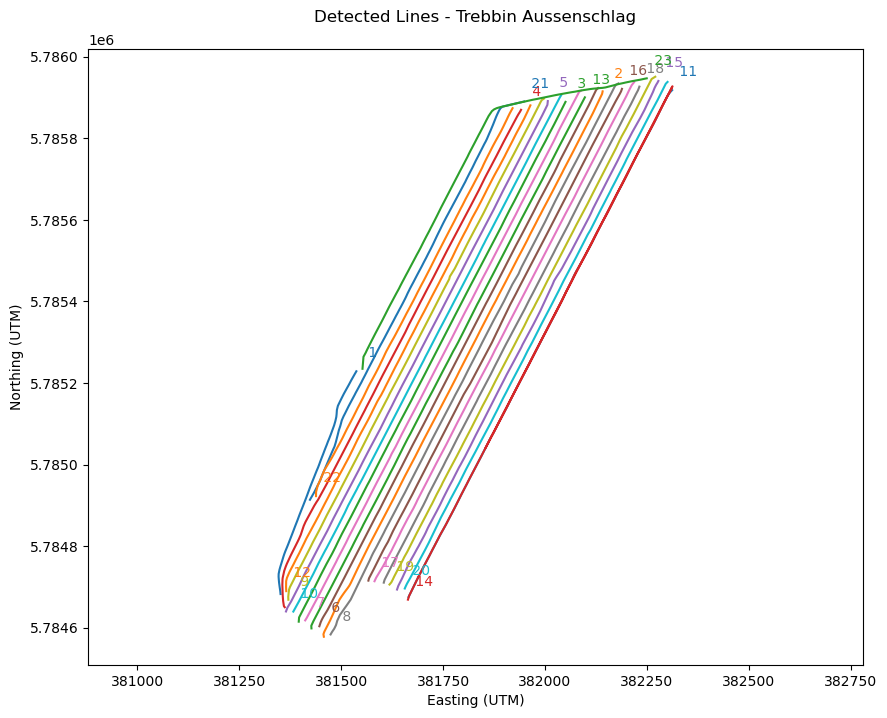

In [33]:
    ## line detection and assign one line to each point
    minPoints = 10
    maxAngleDeviation= 31
    data_line_assigned = line_detection_and_assign_lines(downsampled_data, farmName_Original, minPoints, maxAngleDeviation) 
    
    # plot_detected_lines
    plot_detected_lines(data_line_assigned, farmName_Original, refPoints)

We are now able to plot the original resistivity data for each spacing.

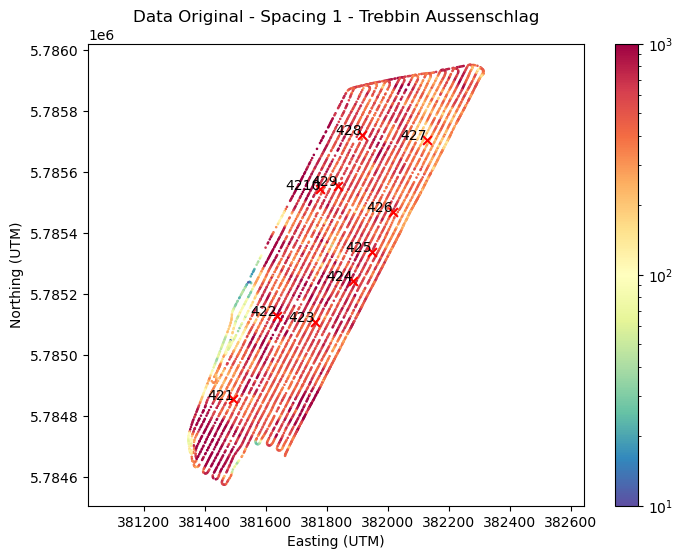

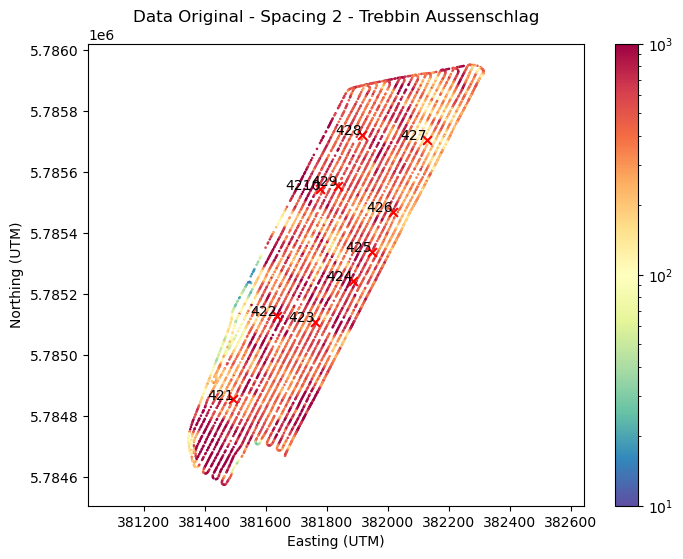

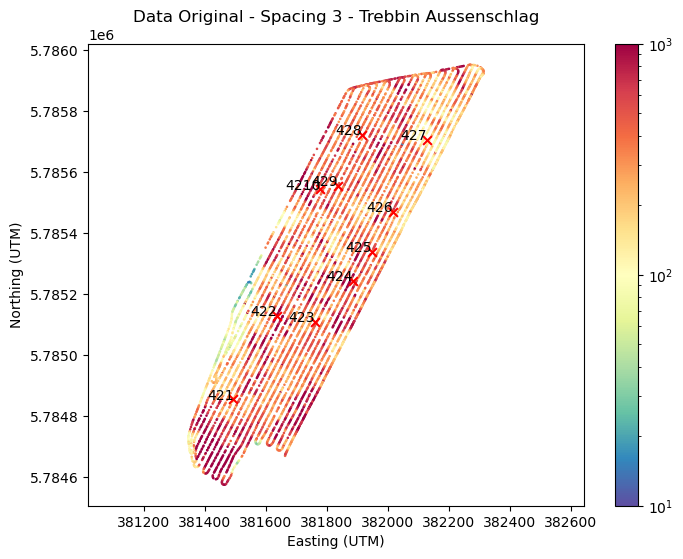

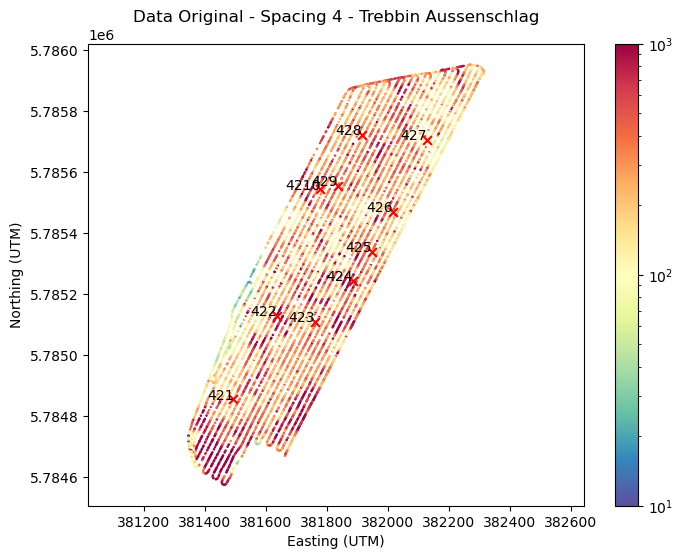

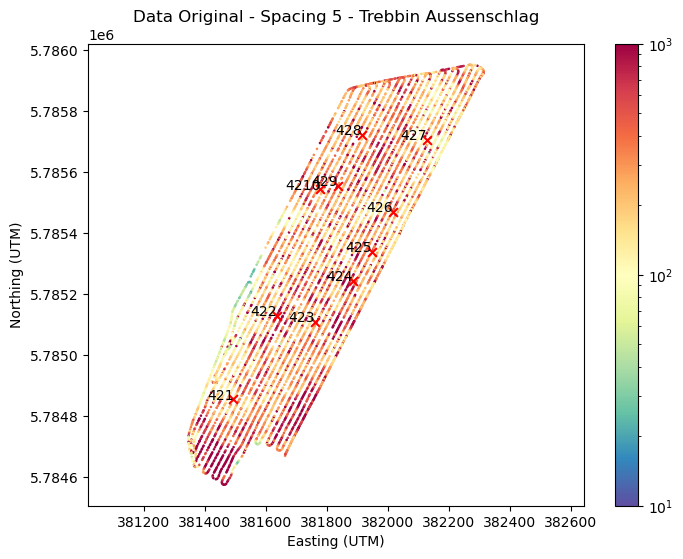

26/02/24 - 15:59:22 - pyGIMLi - INFO - Found image file: DOP381297,5784505,382363,5786020.jpg
C:\Users\Roudsari.S\AppData\Local\Temp\ipykernel_2444\1974655941.py:266: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


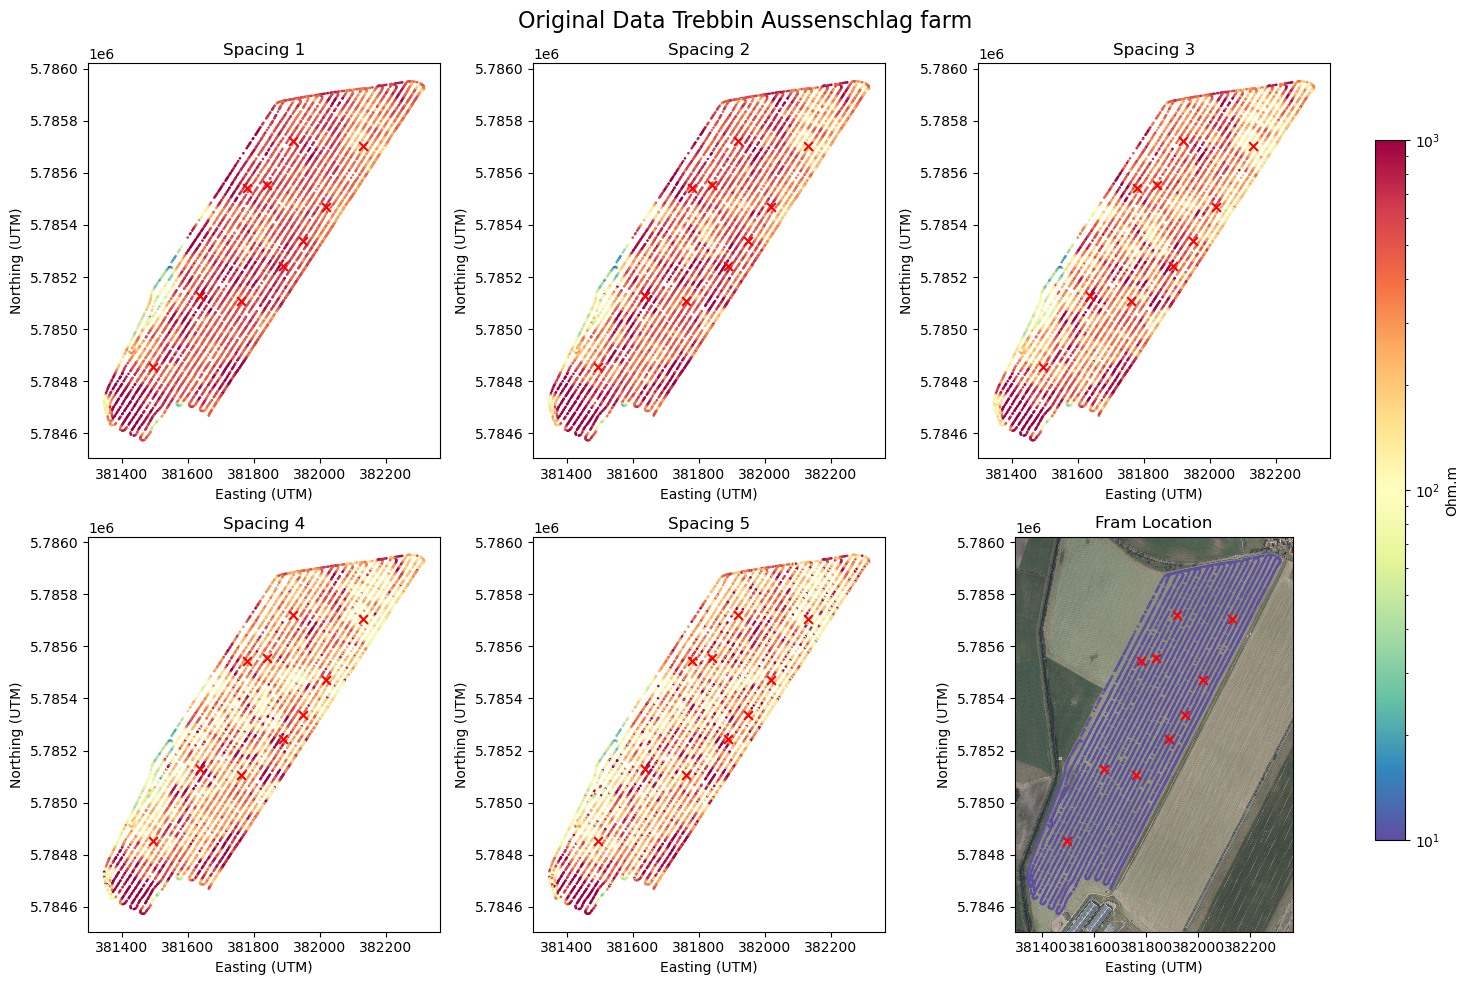

In [8]:
    # Plot original data's areal plot
    data_type_org = 'Original'
    data_org = plot_data(filepath_Original, spacing_labels, farmName_Original, refPoints, data_type_org)
    data_org = plot_data_subplots(filepath_Original, spacing_labels, farmName_Original, refPoints, data_type_org)

Now, we can proceed to apply the Local Outlier Factor (LOF) algorithm to the original data.

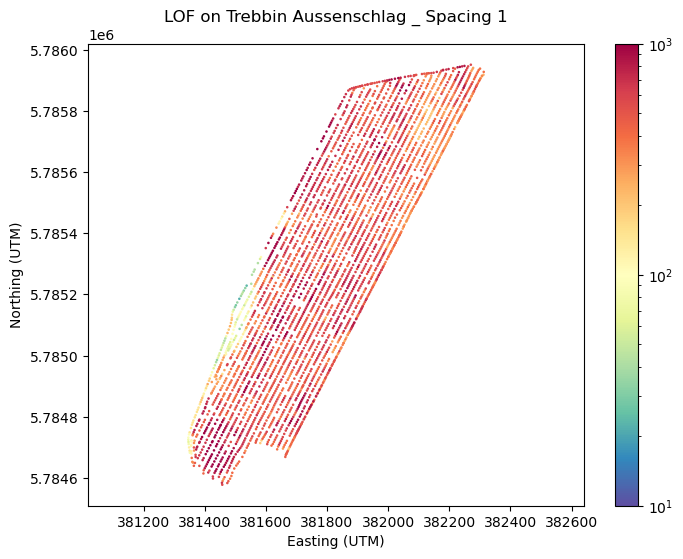

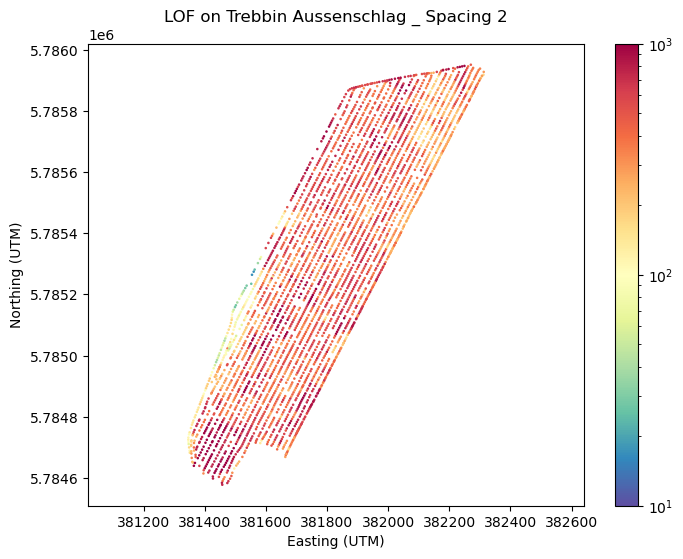

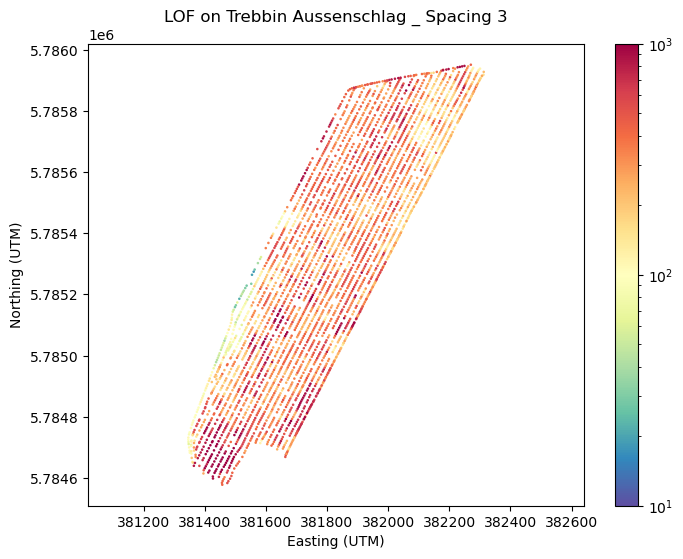

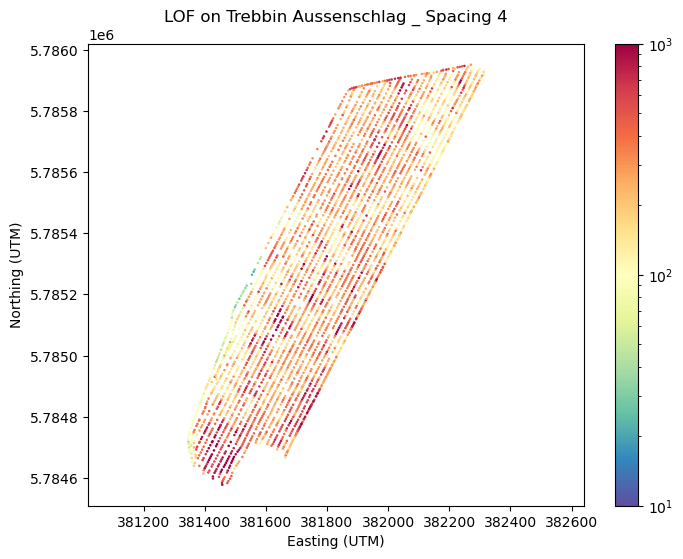

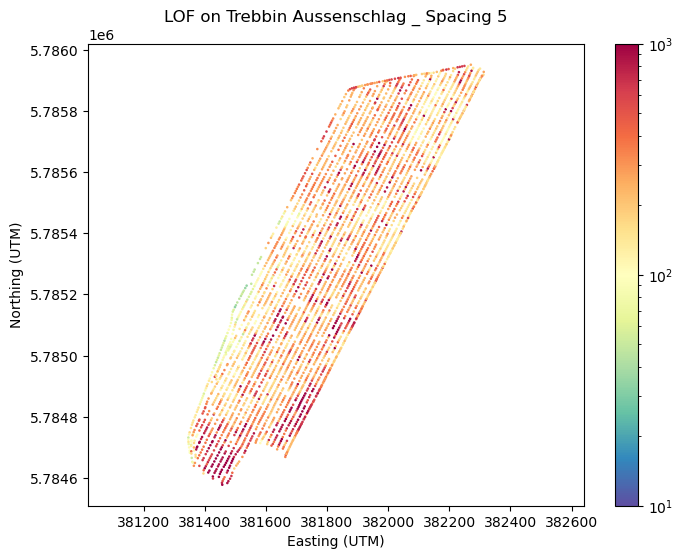

In [9]:
    # LOF on Original
    data_lineIndexed_file = f"data_lineIndexed_{farmName_Original}.txt"
    LOF = LOF_outliers(data_lineIndexed_file, spacing_labels, refPoints, farmName_Original)

We are now prepared to apply a curve-fitting method utilizing PyGIMLi, specifically the Harmfit algorithm, which employs harmonic functions, to the LOF data. This will enable us to achieve a smoother dataset.

In [ ]:
 # harmfit on LOF
LOF_data_file = f"LOF_{farmName_Original}.txt"
data_type_LOF = 'LOF'
harmfit_onLOF = harmfit_fn(LOF_data_file, spacing_labels, farmName_Original, refPoints, data_type_LOF)

Here, we can compare the results of our outlier detection and smoothing process with the original data in each profile.

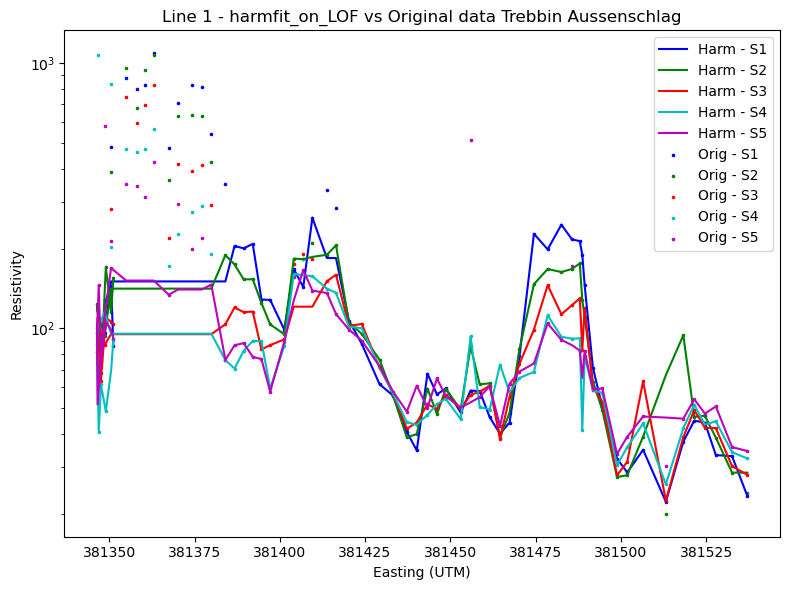

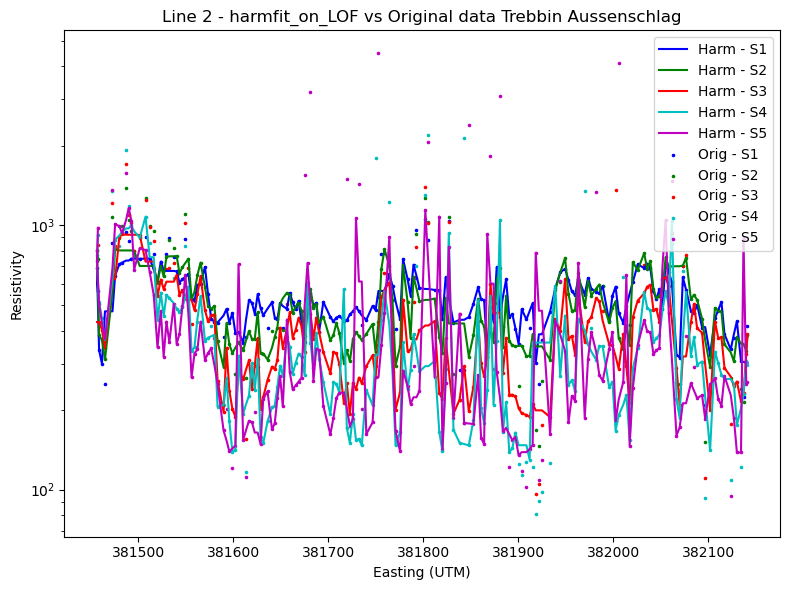

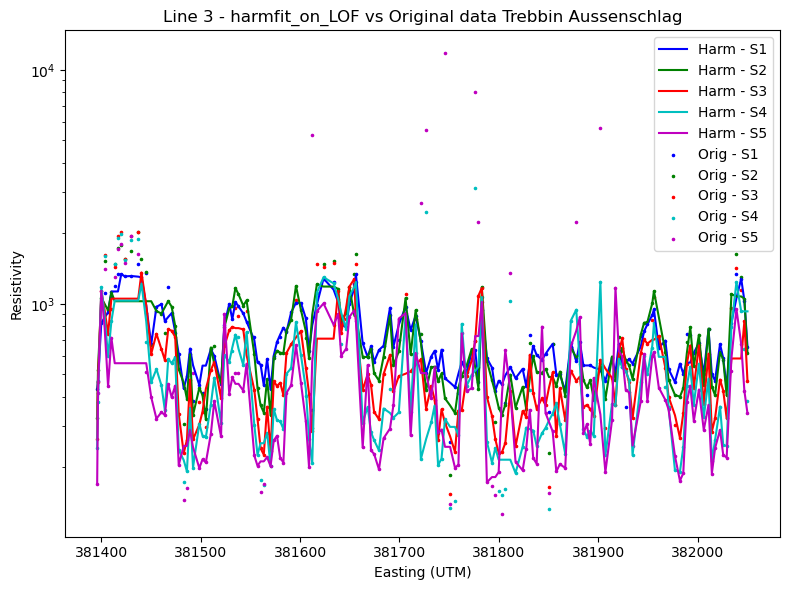

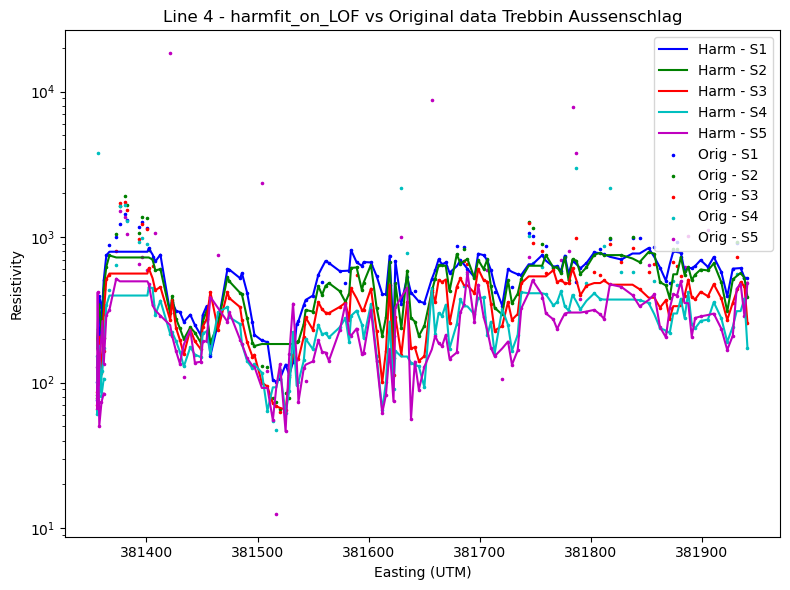

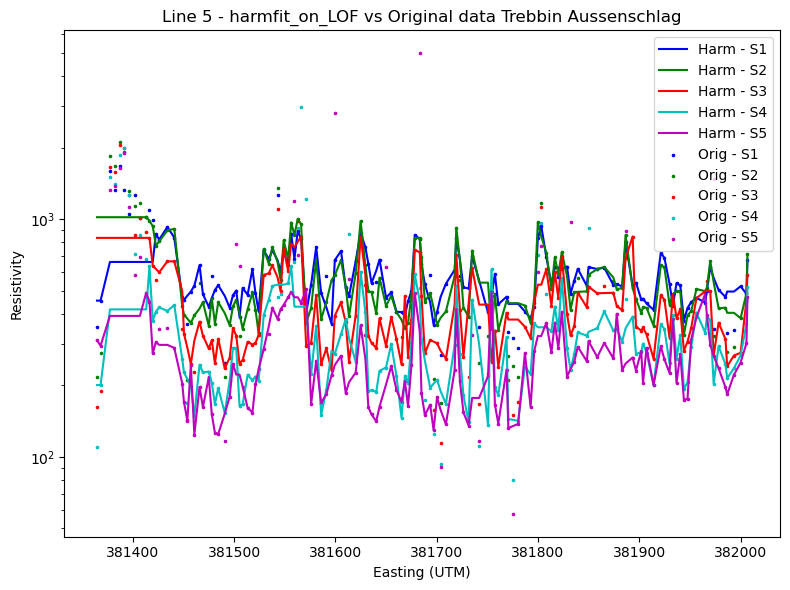

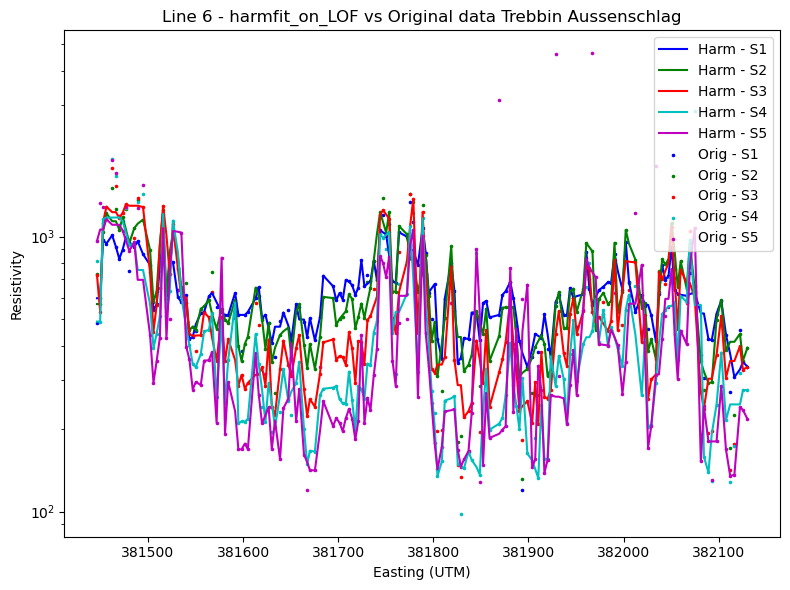

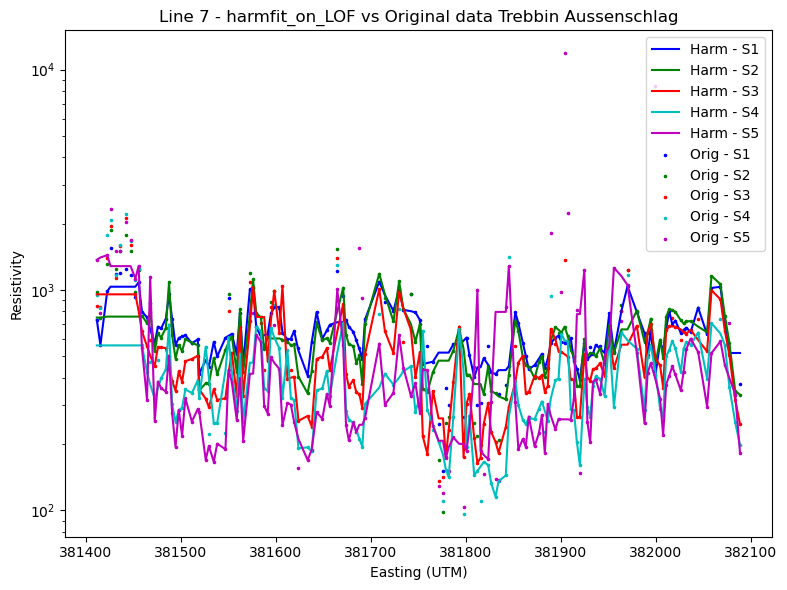

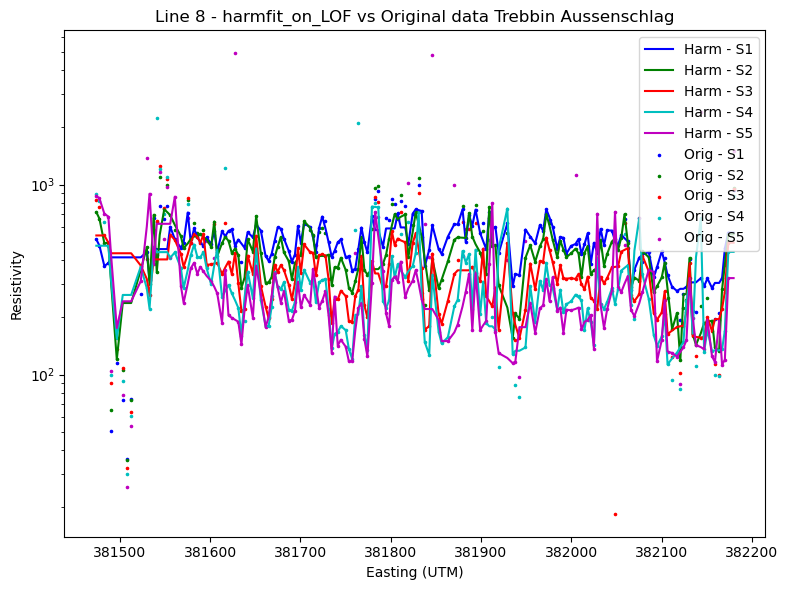

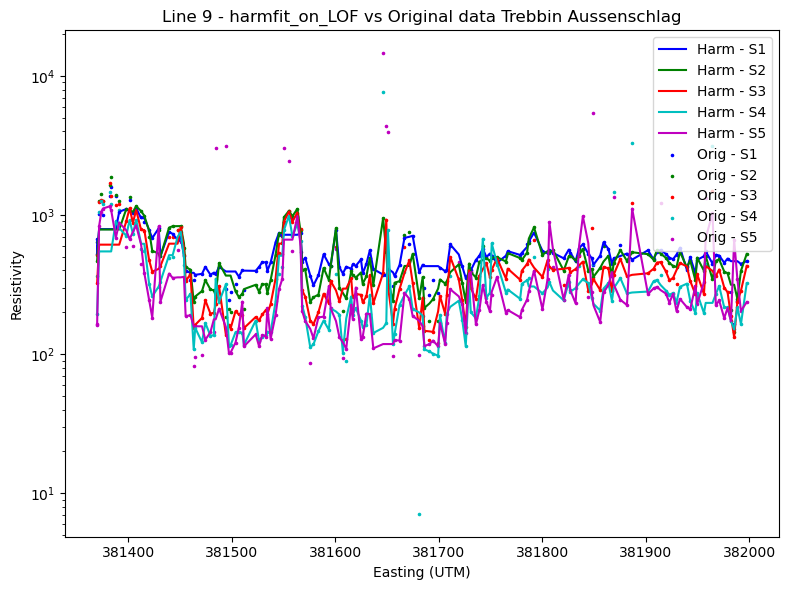

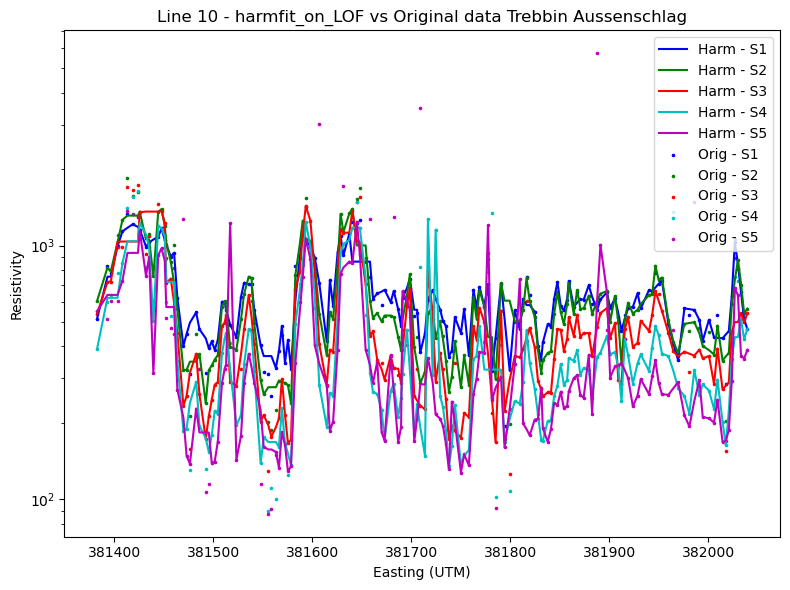

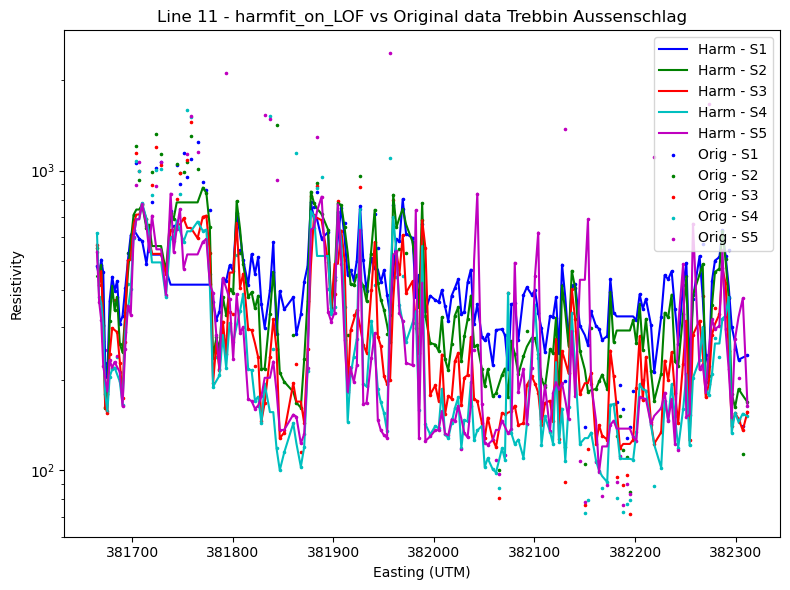

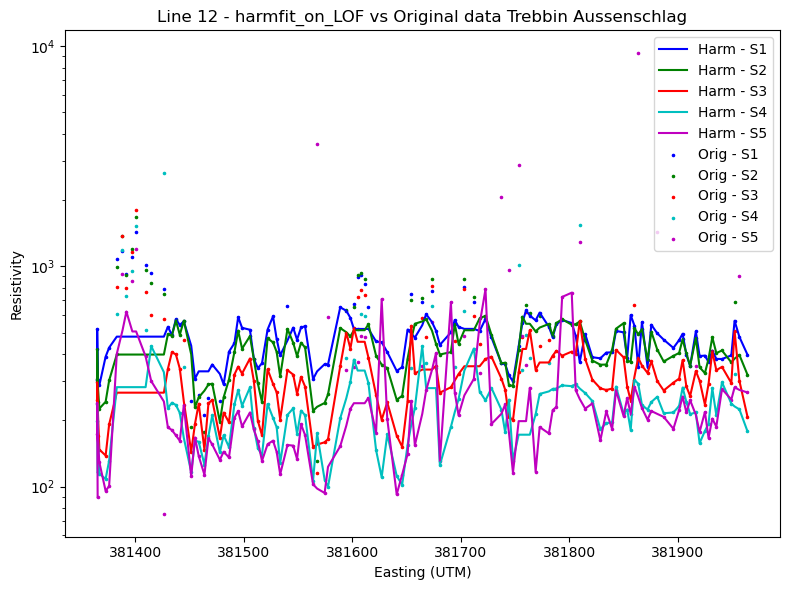

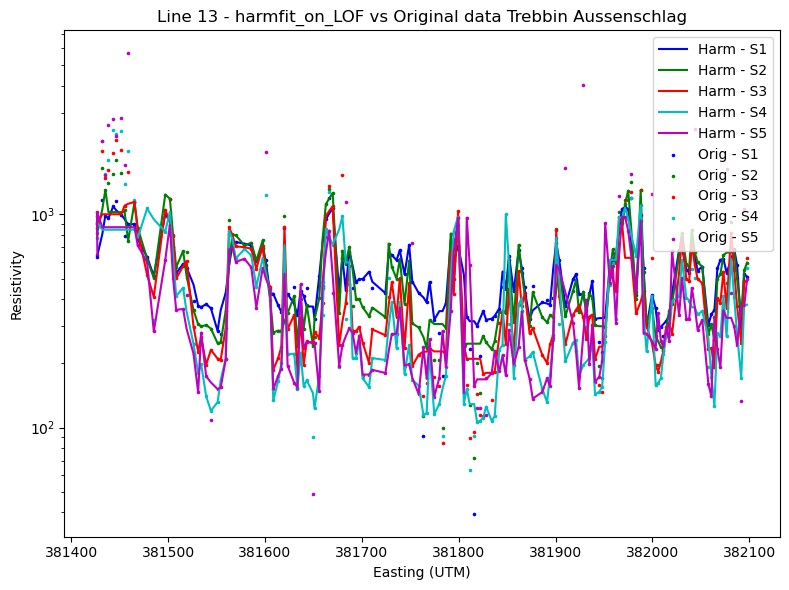

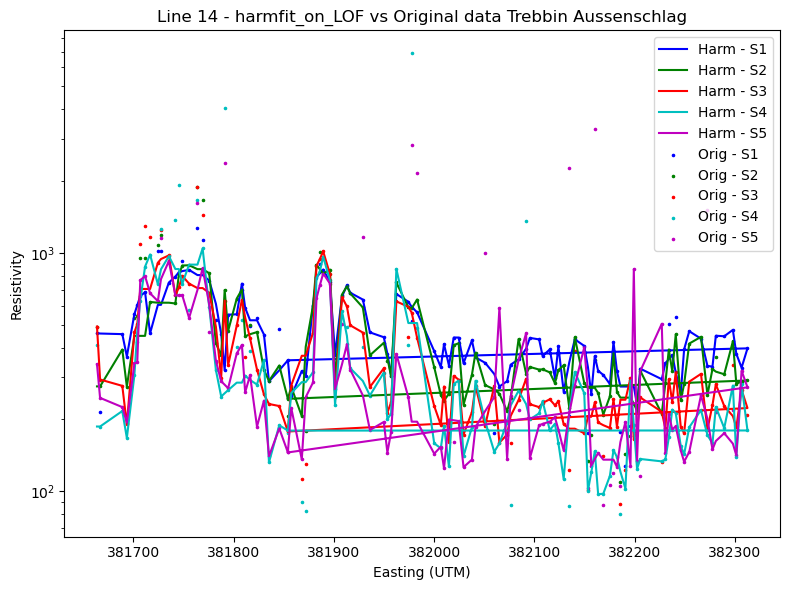

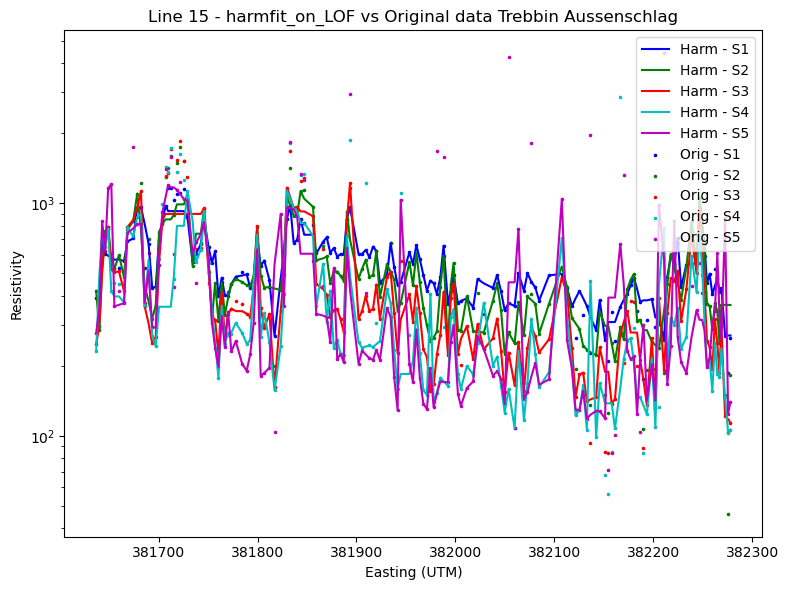

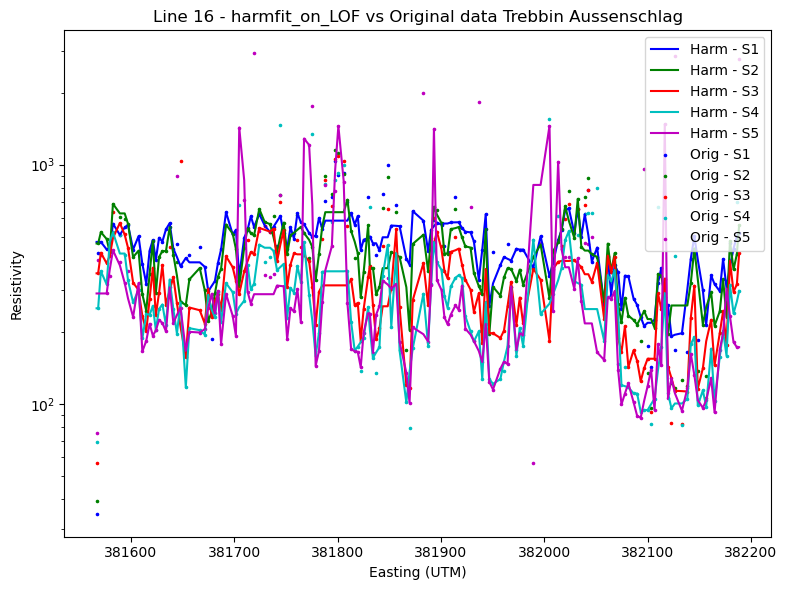

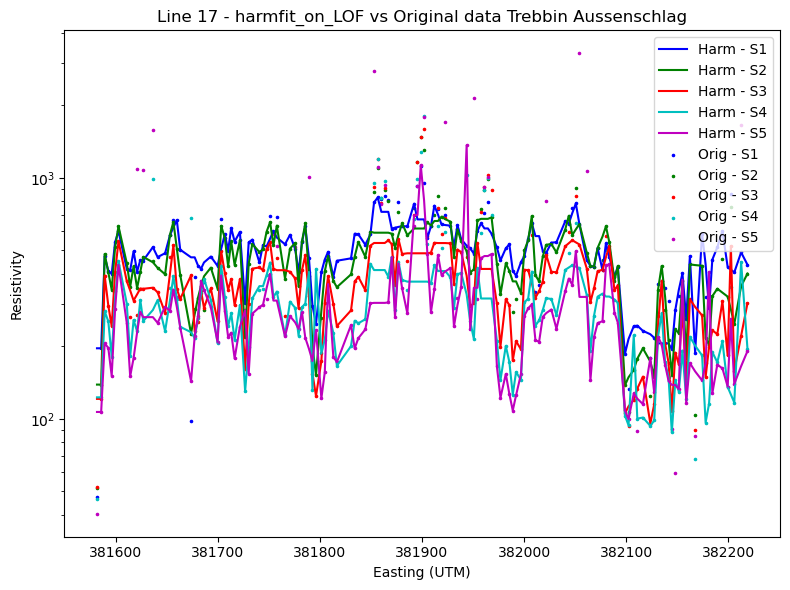

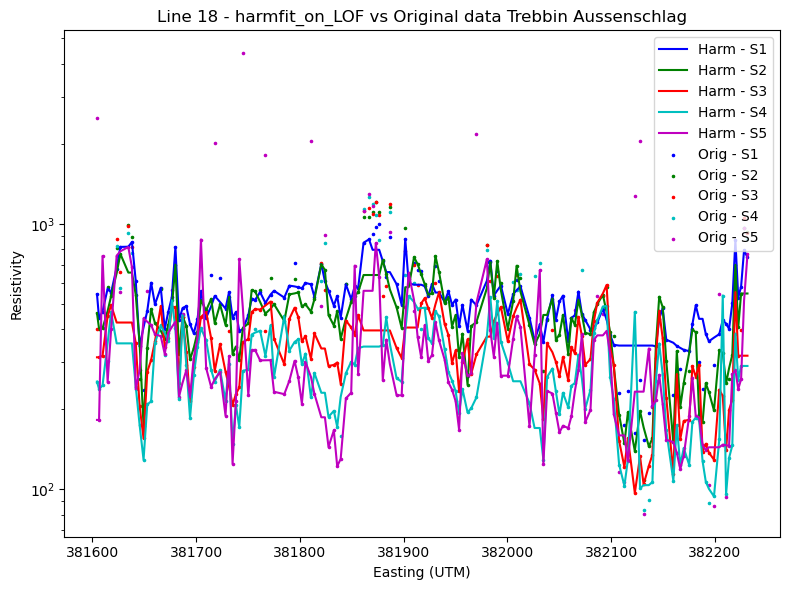

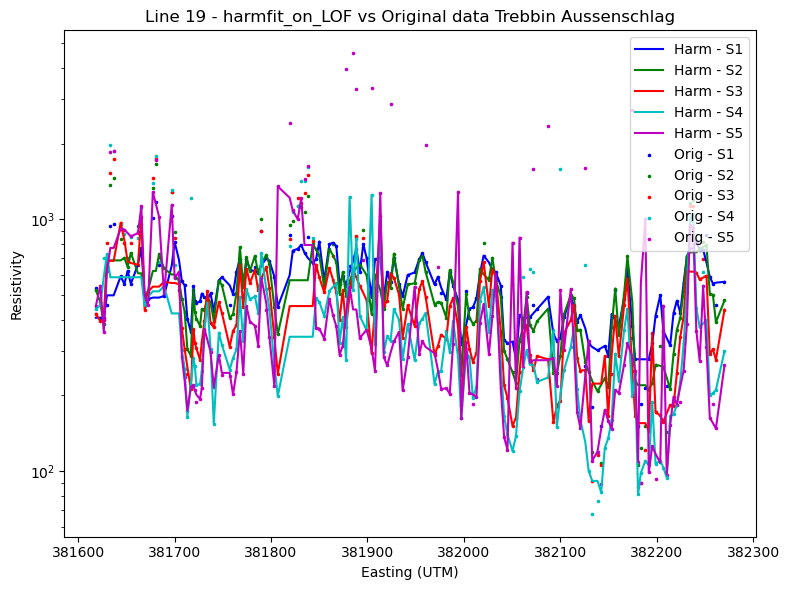

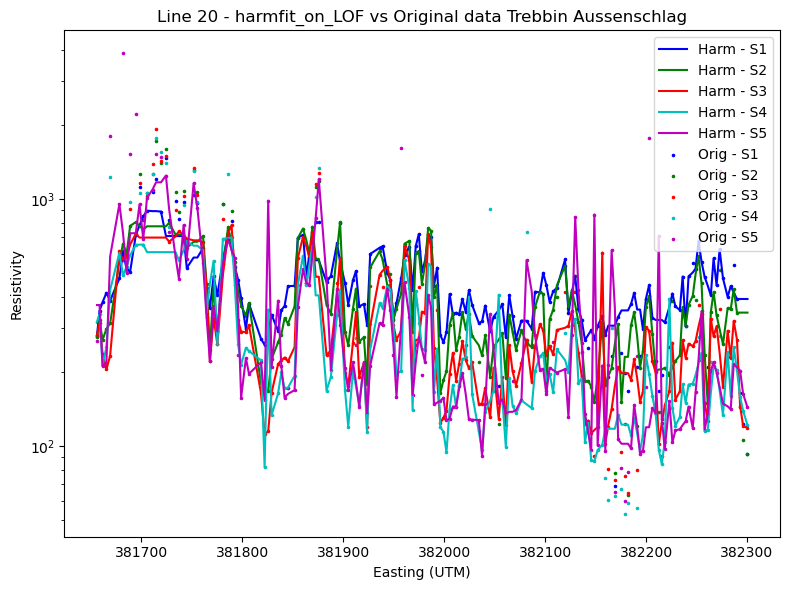

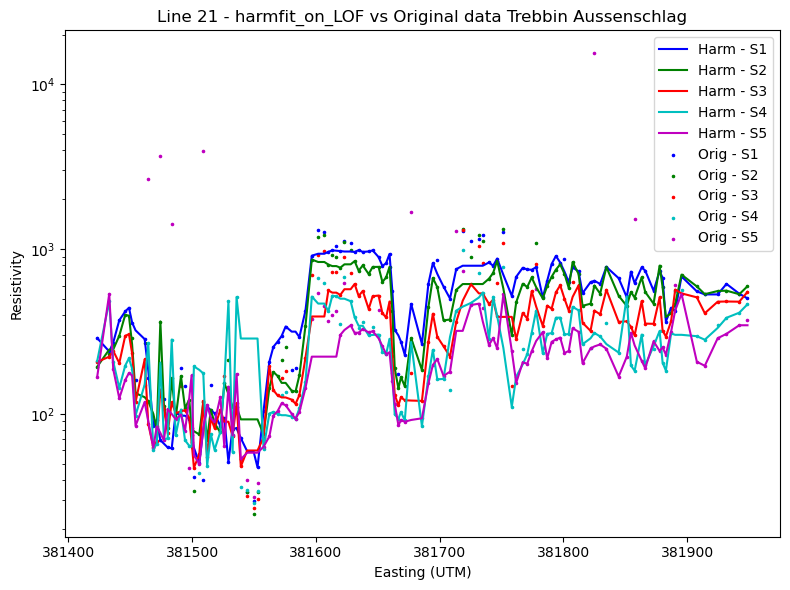

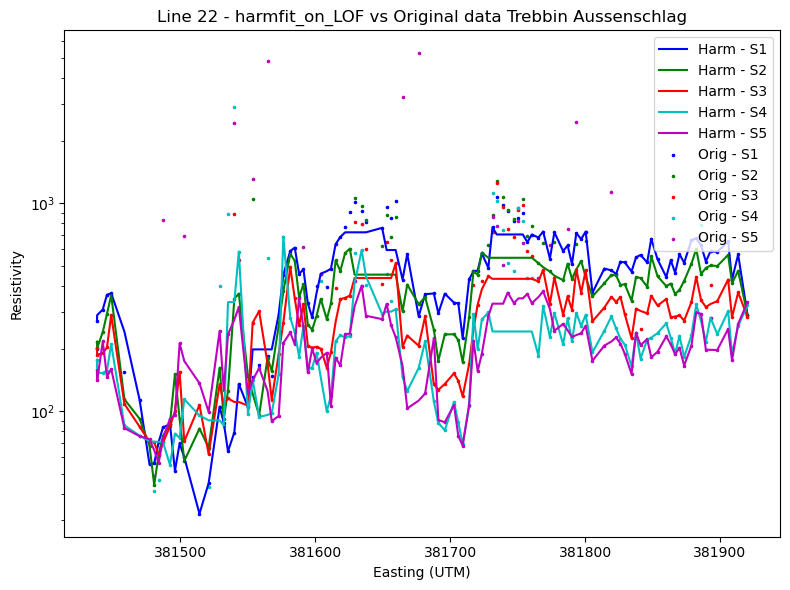

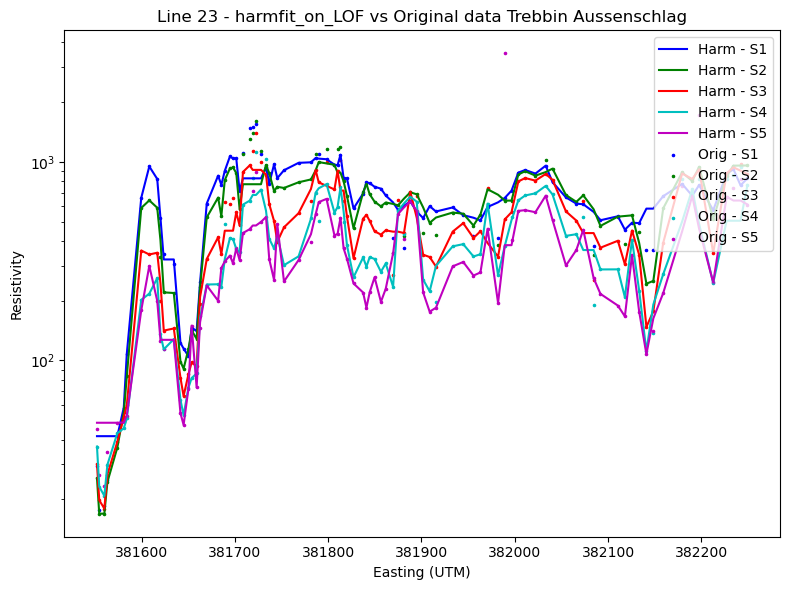

In [13]:
#%% compare the harmfitted data with the 'original data' for each line and spacing
def plot_harmfit_vs_original(filepath, farmName_Original, data_type):
    spacing_labels = ['S1', 'S2', 'S3', 'S4', 'S5']
    # Read original data
    data = read_data_lineIndexed(filepath)
    data_filtered = data[data[:, -1] != 0] # remove individual points
    
    # # Get the indices that would sort the last column in descending order
    # sorted_indices_desc = np.argsort(data_filtered[:, -1])
    # # Reorder data_filtered based on the sorted indices in descending order
    # data_filtered_sorted_desc = data_filtered[sorted_indices_desc]

    
    selected_lines = np.unique(data_filtered[:,-1])
    Eutm_O, Rho_original = data_filtered[:, 0], data_filtered[:, 3:8]

    # Define the color map for spacing plots
    colors_ = ['b', 'g', 'r', 'c', 'm']

    harmfit_file = np.genfromtxt(f"{data_type_LOF}_{farmName_Original}.txt", delimiter=',', skip_header=0)
    x_Harmfit = harmfit_file[:, 0]
    y_Harmfit = harmfit_file[:, 1]

    pdf_filename = f"compare harmfit_on_{data_type} vs Original-{farmName_Original}.pdf"
    pdf_pages = PdfPages(pdf_filename)

    for line_idx, line_num in enumerate(selected_lines, start=1):
        point_indices_of_interest = np.where(data_filtered[:,-1] == line_num)[0]

        # plotting
        fig, ax = plt.subplots(figsize=(8, 6))
        for j, spacing in enumerate(spacing_labels):
            ax.plot(
                harmfit_file[:, 0][point_indices_of_interest],
                harmfit_file[:, j + 3][point_indices_of_interest],
                label=f'Harm - {spacing}', # Sm.Ha: Smoothed_harmfit 
                color=colors_[j]
            )

        for j, rho in enumerate(Rho_original.T):
            ax.scatter(
                Eutm_O[point_indices_of_interest],
                rho[point_indices_of_interest],
                label=f'Orig - {spacing_labels[j]}',
                color=colors_[j],
                marker='.',
                s=10
            )

        ax.set_xlabel('Easting (UTM)')
        ax.set_ylabel('Resistivity')
        ax.set_title(f'Line {line_idx} - harmfit_on_{data_type} vs Original data {farmName_Original}')
        ax.set_yscale('log')
        ax.legend(loc='upper right')

        plt.tight_layout()
        plt.show()
        pdf_pages.savefig(fig)
        plt.close()

    pdf_pages.close()
    
    # Call the function with appropriate arguments
farmName_Original = 'Trebbin Aussenschlag'
data_lineIndexed_file = f"data_lineIndexed_{farmName_Original}.txt"
data_lineIndexed_file
# compare harmfit on LOF vs original
data_type_LOF = 'LOF'
plot_harmfit_vs_original(data_lineIndexed_file, farmName_Original, data_type_LOF)